In [19]:
import xarray as xr
import geopandas as gpd
import fsspec
import numpy as np
from rasterio import features
from affine import Affine
import pandas as pd
import hvplot.pandas
import hydrotools as ht
import os
import matplotlib.pyplot as plt
import warnings
from dask.distributed import Client, progress
warnings.filterwarnings('ignore')

In [ ]:
# Seulement utiilser dans un cluster Kubernetes
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

In [ ]:
client = Client(cluster)
client

# Repertoires

In [13]:
# Repertoire contenant les shapefiles ou geojson
shp_files = 's3://watersheds-polygons/MELCC/json'

# Nom du bucket contenant les donnees ERA5-Land
bucket='s3://era5-atlantic-northeast/zarr/land/reanalysis'


# Configs

In [14]:
# Url du serveur contenant le bucket
client_kwargs={"endpoint_url":"https://s3.us-east-2.wasabisys.com"}

# Geopandas

In [15]:
epsg_ini = 4326
# Shapefiles/json to geopandas
gdf = ht.files_to_gdf(url=shp_files,
                      epsg=epsg_ini,
                      client_kwargs=client_kwargs)  
gdf

,OBJECTID,Station,Sup_Km,Nom,Descriptio,Type_stat,Etat,Regime,Altitude,Proprietai,Latitude,Longitude,SUPERFICIE,Inclus,Shape_Leng,tp,Shape_Le_1,Shape_Area,geometry
0,1,ST_010101,530.602589599,La Grande Rivière,"à 2,3 km en amont de la branche ouest",Débit,Fermé,Naturel,50.3,MENV,48.4777777778,-64.52861111110001,534,oui,169650.548302,010101,1.97437542906,0.0652761069343,POLYGON ((-64.63738271199992 48.69413109900006...
1,2,ST_010801,2112.20913932,Bonaventure,"à 9,7 km en amont du pont-route 132",Débit,Fermé,Naturel,15.2,MENV,48.1000238888,-65.4609027022,2130,oui,314860.080669,010801,3.50969600722,0.259261186252,POLYGON ((-65.72905017199992 48.91156354000009...


# Xarray Dataset

In [24]:
# Mapping vers filesystem depuis le bucket
store = fsspec.get_mapper(url=bucket,
                          client_kwargs=client_kwargs,
                          anon=True)

# Ouverture du zarr vers dataset (xarray)
ds = xr.open_zarr(store,
                  consolidated=True,
                  chunks='auto')
ds

<xarray.Dataset>
Dimensions:    (latitude: 231, longitude: 441, time: 339648)
Coordinates:
  * latitude   (latitude) float32 63.0 62.9 62.8 62.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 -96.0 -95.9 -95.8 -95.7 ... -52.2 -52.1 -52.0
  * time       (time) datetime64[ns] 1981-01-01 ... 2019-09-30T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    licd       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    smlt       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    snowc      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-14 15:35:10 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

Pour plus d'informations sur les variables disponibles :

In [ ]:
# ds.variables

Prenons par exemple la variable sd (snow depth water equivalent) :

In [23]:
ds.sd.data

,Array,Chunk
Bytes,138.40 GB,21.90 MB
Shape,"(339648, 231, 441)","(8760, 25, 25)"
Count,7021 Tasks,7020 Chunks
Type,float32,numpy.ndarray


# Application des moyennes bassins (xarray vers dataframe)

In [16]:
%%time

df = ht.clip_polygon_to_dataframe(dataset=ds,
                                  geodataframe=gdf[0:4], # prendre seulement les 3 premiers pour fin de tests
                                  geodf_index_column='Station',
                                  variable='sd',  
                                  aggregation='mean',
                                  resample_time='1D',
                                  from_tz='UTC',
                                  to_tz='America/Montreal',
                                  latlng_names=['latitude',
                                                'longitude']
                                  )
# Convertir vers le format de l'IC
# df.index = df.index.tz_convert(None).normalize() + pd.DateOffset(days=1)

ST_010101
CPU times: user 11.8 s, sys: 2.35 s, total: 14.1 s
Wall time: 12.6 s


# Dataframe

In [10]:
df

,Arnprior,Bark Lake,Barrage des Rapides-des-Cèdres (040602),Barrage Kiamika (040608)
time,,,,
1980-12-31 00:00:00-05:00,0.070404,0.112433,0.122614,0.143668
1981-01-01 00:00:00-05:00,0.070424,0.112526,0.122584,0.143668
1981-01-02 00:00:00-05:00,0.073008,0.115272,0.124959,0.145838
1981-01-03 00:00:00-05:00,0.073187,0.115408,0.125825,0.146899
1981-01-04 00:00:00-05:00,0.073262,0.115518,0.126079,0.147230
...,...,...,...,...
2019-09-26 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000
2019-09-27 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000
2019-09-28 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000


# Visualisation rapide

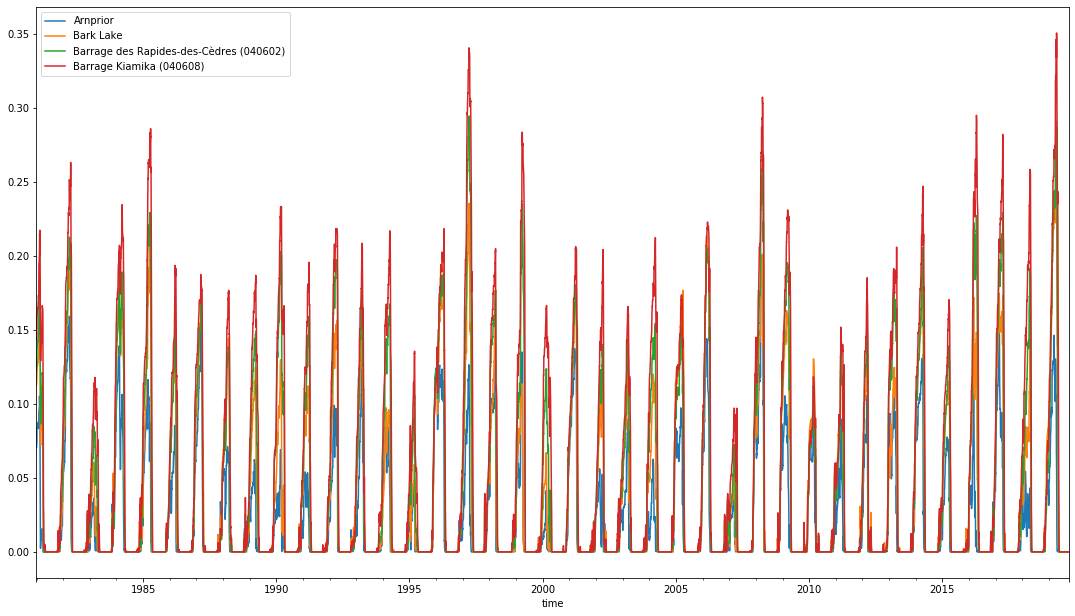

In [11]:
df.plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)